### IMPORT LIBRIARIES

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from pandasql import sqldf

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adeyehat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adeyehat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### READ IN DATA

In [2]:
data = pd.concat([pd.read_csv(r'BBC DATASET 3.csv'),pd.read_csv(r'BBC NEWS DATASET 1.csv'),pd.read_csv(r'BBC NEWS DATASET.csv'),pd.read_csv(r'BBCJULNOV21.csv'),pd.read_csv(r'BBCNEWSAPRJUN21.csv'),pd.read_csv(r'BBCNEWSJANMAR21.csv')],axis = 0)

In [3]:
data.to_csv('raw_data.csv')

In [4]:
data.reset_index(drop = True, inplace = True)

### PREPROCESS 1
- Drop unnecessary fields
- Drop Nulls
- Convert time to hours
- Convert Boolean fields to Numeric

In [5]:
data.dropna(inplace= True)

In [6]:
data.drop(['screenname','ID'],axis = 1,inplace = True)

In [7]:
data['time'] = pd.to_datetime(data['time']).dt.hour

In [8]:
data['Video'] = data['Video'].apply(lambda x: 0 if x == False else 1)

In [9]:
data['retweeted'] = data['retweeted'].apply(lambda x: 0 if x == False else 1)

In [10]:
data['pinned'] = data['pinned'].apply(lambda x: 0 if x == False else 1)

#### REPLACE 'K' in numeric columns with X1000

In [11]:
def convert_abbreviated_count(x):
    if str(x).isnumeric():
        return int(x)
    else:
        if 'k' in str(x).lower():
            return int(float(x [:-1]) * 1000)
        elif 'm' in str(x).lower():
            return int(float(x [:-1]) * 1000000)
        return 0

In [12]:
data['replies'] = data['replies'].apply(lambda x : convert_abbreviated_count(x))
data['retweets'] = data['retweets'].apply(lambda x : convert_abbreviated_count(x))
data['likes'] = data['likes'].apply(lambda x : convert_abbreviated_count(x))

### COMPUTE POPULARITY METRICS
- To serve as target/dependent variable

In [13]:
def calculate_popularity_metrics(row):
    return round(((row.replies * 0.25) + (row.retweets * 0.3) + (row.likes * 0.45)),2)

In [14]:
data['popularity'] =  [calculate_popularity_metrics(y) for x,y in data.iterrows()]

### PREPROCESS 2 - FEATURE ENGINEERING I
- Create new features that would give the data more meaning e.g count length of content

In [15]:
data['length_content'] = data['content'].apply(lambda x : len(x))

#### REMOVE STOPWORD
- Stopwords are words with no semantic meaning
- Tokenize is the process of breaking up a string in a list of words

In [16]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

In [17]:
def remove_stopwords(x):
    return [y for y in word_tokenize(x) if y.lower() not in stop_words]

In [18]:
data['content_w_stopwords'] = data['content'].apply(lambda x : remove_stopwords(x))

In [19]:
data['length_content_w_stopwords'] = data['content_w_stopwords'].apply(lambda x : len(x))

### EXPLORATORY DATA ANALYSIS WITH WORDCLOUD
- bin popularity column to see words that are common to the different bins of popularity

In [20]:
data.describe()

,time,replies,retweets,likes,photos,Video,retweeted,pinned,popularity,length_content,length_content_w_stopwords
count,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.0,3941.000000,3941.000000,3941.000000
mean,13.508754,52.335955,61.265669,192.649328,0.879472,0.032225,0.017762,0.0,118.155887,77.167470,10.304491
std,5.777845,133.527085,257.096764,507.485500,0.337108,0.176620,0.132102,0.0,307.117785,38.777268,5.062819
min,0.000000,1.000000,0.000000,4.000000,-1.000000,0.000000,0.000000,0.0,4.400000,22.000000,2.000000
25%,9.000000,11.000000,14.000000,53.000000,1.000000,0.000000,0.000000,0.0,32.800000,54.000000,7.000000
50%,14.000000,22.000000,26.000000,86.000000,1.000000,0.000000,0.000000,0.0,54.500000,64.000000,9.000000
75%,18.000000,46.000000,52.000000,174.000000,1.000000,0.000000,0.000000,0.0,109.300000,87.000000,12.000000
max,23.000000,3100.000000,10700.000000,19300.000000,4.000000,1.000000,1.000000,0.0,10438.750000,279.000000,39.000000


### USING NATURAL GROUPS
- Based on distribution of data

In [21]:
print(f'Median of popularity: {data.popularity.median()}')
bins = [data.popularity.min(),data.popularity.median(),250,data.popularity.max()]
labels =[1,2,3,]
data['binned'] = pd.cut(data['popularity'], bins,labels=labels)
data['binned'].value_counts()

Median of popularity: 54.5


1    1970
2    1594
3     376
Name: binned, dtype: int64

In [22]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [23]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


def wordcloud_draw(text, title="", color="white"):
    """
    Plots wordcloud of string text after removing stopwords
    """
    cleaned_word = " ".join([word for word in text.split() if "http" not in word])
    wordcloud = WordCloud(
        stopwords=STOPWORDS, background_color=color, width=1000, height=1000,max_font_size=500
    ).generate(cleaned_word)
    plt.figure(1, figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")
    display(plt.show())

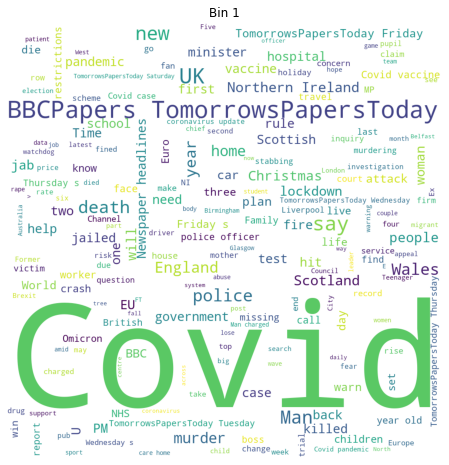

None

In [24]:
text = " ".join(review for review in data[data['binned'] == 1].content)
wordcloud_draw(text, title = "Bin 1")

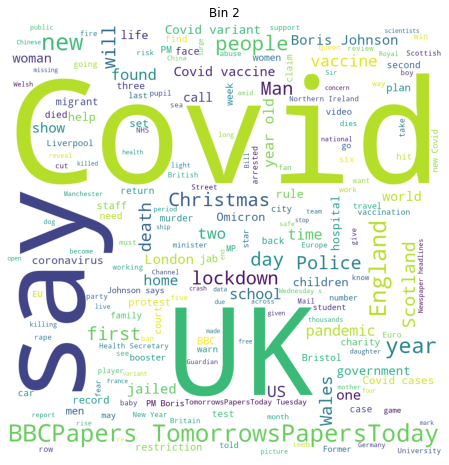

None

In [25]:
text = " ".join(review for review in data[data['binned'] == 2].content)
wordcloud_draw(text, title = "Bin 2")

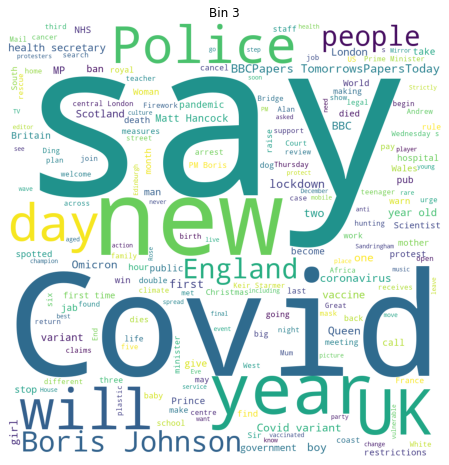

None

In [26]:
text = " ".join(review for review in data[data['binned'] == 3].content)
wordcloud_draw(text, title = "Bin 3")

In [27]:
# text = " ".join(review for review in data[data['binned'] == 4].content)
# wordcloud_draw(text, title = "Bin 4")

### PLOT KDE FOR POPULARITY TO REVIEW OUTLIERS
- Kernel Desnsity plot is used to see the distribution of your dataset. From here you can tell if your data is normally distributed or has outliers

<AxesSubplot:xlabel='popularity', ylabel='Density'>

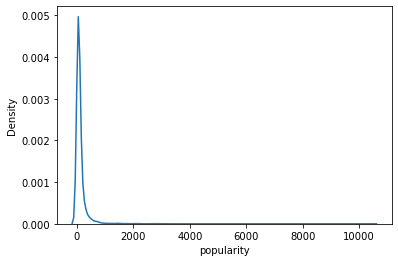

In [28]:
import seaborn as sns
%matplotlib inline
sns.kdeplot(data['popularity'])

- Boxplot is also a good visualization tool for finding outliers

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='popularity'>

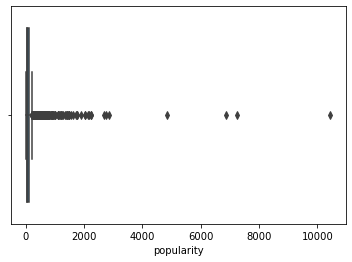

In [29]:
sns.boxplot(data['popularity'])

### REVIEW OUTLIERS

In [30]:
Q1 = data.popularity.quantile(0.25)
Q3 = data.popularity.quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

In [31]:
outliers = (round((len(data[(data['popularity'] > upper_limit) | (data['popularity'] < lower_limit)])/len(data)),2) * 100)
print(f'Percentage Outlier based on popularity: {outliers}%')

Percentage Outlier based on popularity: 11.0%


### PREPROCESS 3 - REMOVING OUTLIERS
- REMOVING OUTLIERS BASED ON POPULARITY

### PREPROCESS 4 - FEATURE ENGINEERING - TFIDF

In [33]:
%pip install texthero
import texthero as hero
from texthero import preprocessing
custom_pipeline = [preprocessing.fillna,
                   #preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_diacritics
                   #preprocessing.remove_brackets
                  ]
data['clean_text'] = hero.clean(data['content'], custom_pipeline)
data['clean_text'] = [n.replace('{','') for n in data['clean_text']]
data['clean_text'] = [n.replace('}','') for n in data['clean_text']]
data['clean_text'] = [n.replace('(','') for n in data['clean_text']]
data['clean_text'] = [n.replace(')','') for n in data['clean_text']]
data['tfidf'] = (hero.tfidf(data['clean_text'], max_features=3000))

Note: you may need to restart the kernel to use updated packages.


### WORDCLOUD WITH CLEANED DATA

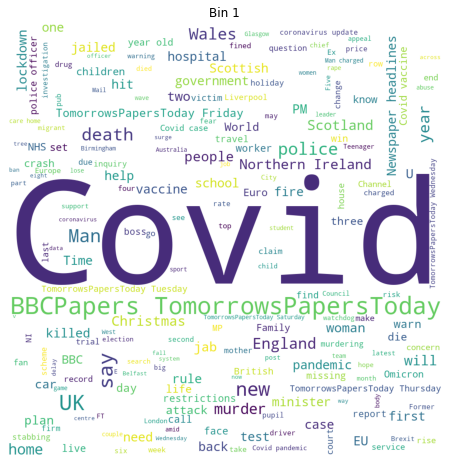

None

In [35]:
text = " ".join(review for review in data[data['binned'] == 1].clean_text)
wordcloud_draw(text, title = "Bin 1")

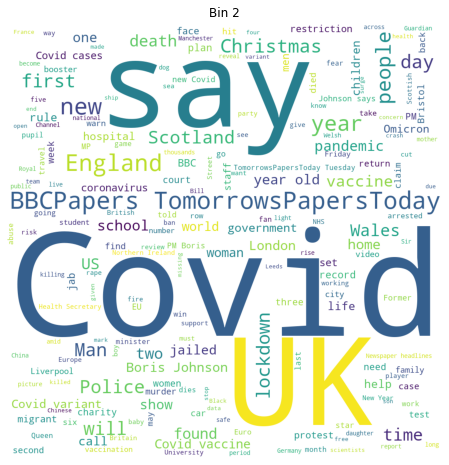

None

In [36]:
text = " ".join(review for review in data[data['binned'] == 2].clean_text)
wordcloud_draw(text, title = "Bin 2")

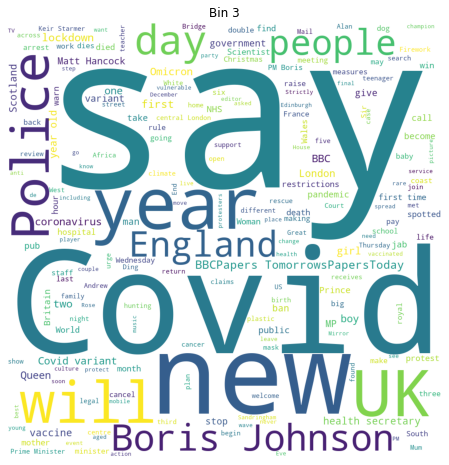

None

In [37]:
text = " ".join(review for review in data[data['binned'] == 3].clean_text)
wordcloud_draw(text, title = "Bin 3")

### FEATURE ENGINEERING - VADER SENTIMENTS
- Used to determine sentiments in a text documents.
- Four results
- One for positive,negative,neutral,compound

In [38]:
%pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()

Note: you may need to restart the kernel to use updated packages.


In [39]:
data['Vader'] = data['content'].apply(lambda x: sid_obj.polarity_scores(x))

In [40]:
data['vader_neg'] = data['Vader'].apply(lambda x : x['neg'])
data['vader_pos'] = data['Vader'].apply(lambda x : x['pos'])
data['vader_neu'] = data['Vader'].apply(lambda x : x['neu'])
data['vader_compound'] = data['Vader'].apply(lambda x : x['compound'])

In [41]:
data.head(1)

,time,content,replies,retweets,likes,photos,Video,retweeted,pinned,popularity,...,content_w_stopwords,length_content_w_stopwords,binned,clean_text,tfidf,Vader,vader_neg,vader_pos,vader_neu,vader_compound
0,18,Motor Neurone dad receives £11k to help him sp...,11,27,487,-1,0,0,0,230.0,...,"[Motor, Neurone, dad, receives, £11k, help, sp...",10,2,Motor Neurone dad receives PS11k to help him s...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp...",0.0,0.184,0.816,0.4019


### FEATURE ENGINEERING - TEXTBLOB SENTIMENTS
- Similar to Vader but introduces a subjectivity metric
- Only 2 results

In [42]:
%pip install textblob
from textblob import TextBlob

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
  
 #Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

Note: you may need to restart the kernel to use updated packages.


In [43]:
data['TextBlob_Subjectivity'] = data['content'].apply(getSubjectivity)
data['TextBlob_Polarity'] = data['content'].apply(getPolarity)

In [44]:
data.head(1)

,time,content,replies,retweets,likes,photos,Video,retweeted,pinned,popularity,...,binned,clean_text,tfidf,Vader,vader_neg,vader_pos,vader_neu,vader_compound,TextBlob_Subjectivity,TextBlob_Polarity
0,18,Motor Neurone dad receives £11k to help him sp...,11,27,487,-1,0,0,0,230.0,...,2,Motor Neurone dad receives PS11k to help him s...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp...",0.0,0.184,0.816,0.4019,1.0,0.0


In [45]:
data.to_csv('cleaned.csv')

### EXPLORATORY DATA ANALYSIS - REGRESSION MODELLING
- USING POPULARITY AS TARGET

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3941 entries, 0 to 3941
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   time                        3941 non-null   int64   
 1   content                     3941 non-null   object  
 2   replies                     3941 non-null   int64   
 3   retweets                    3941 non-null   int64   
 4   likes                       3941 non-null   int64   
 5   photos                      3941 non-null   int64   
 6   Video                       3941 non-null   int64   
 7   retweeted                   3941 non-null   int64   
 8   pinned                      3941 non-null   int64   
 9   popularity                  3941 non-null   float64 
 10  length_content              3941 non-null   int64   
 11  content_w_stopwords         3941 non-null   object  
 12  length_content_w_stopwords  3941 non-null   int64   
 13  binned            

In [47]:
data = data[['time','photos','Video','pinned','binned','popularity','length_content','length_content_w_stopwords','vader_neg','vader_pos','vader_neu','vader_compound','TextBlob_Subjectivity','TextBlob_Polarity']]

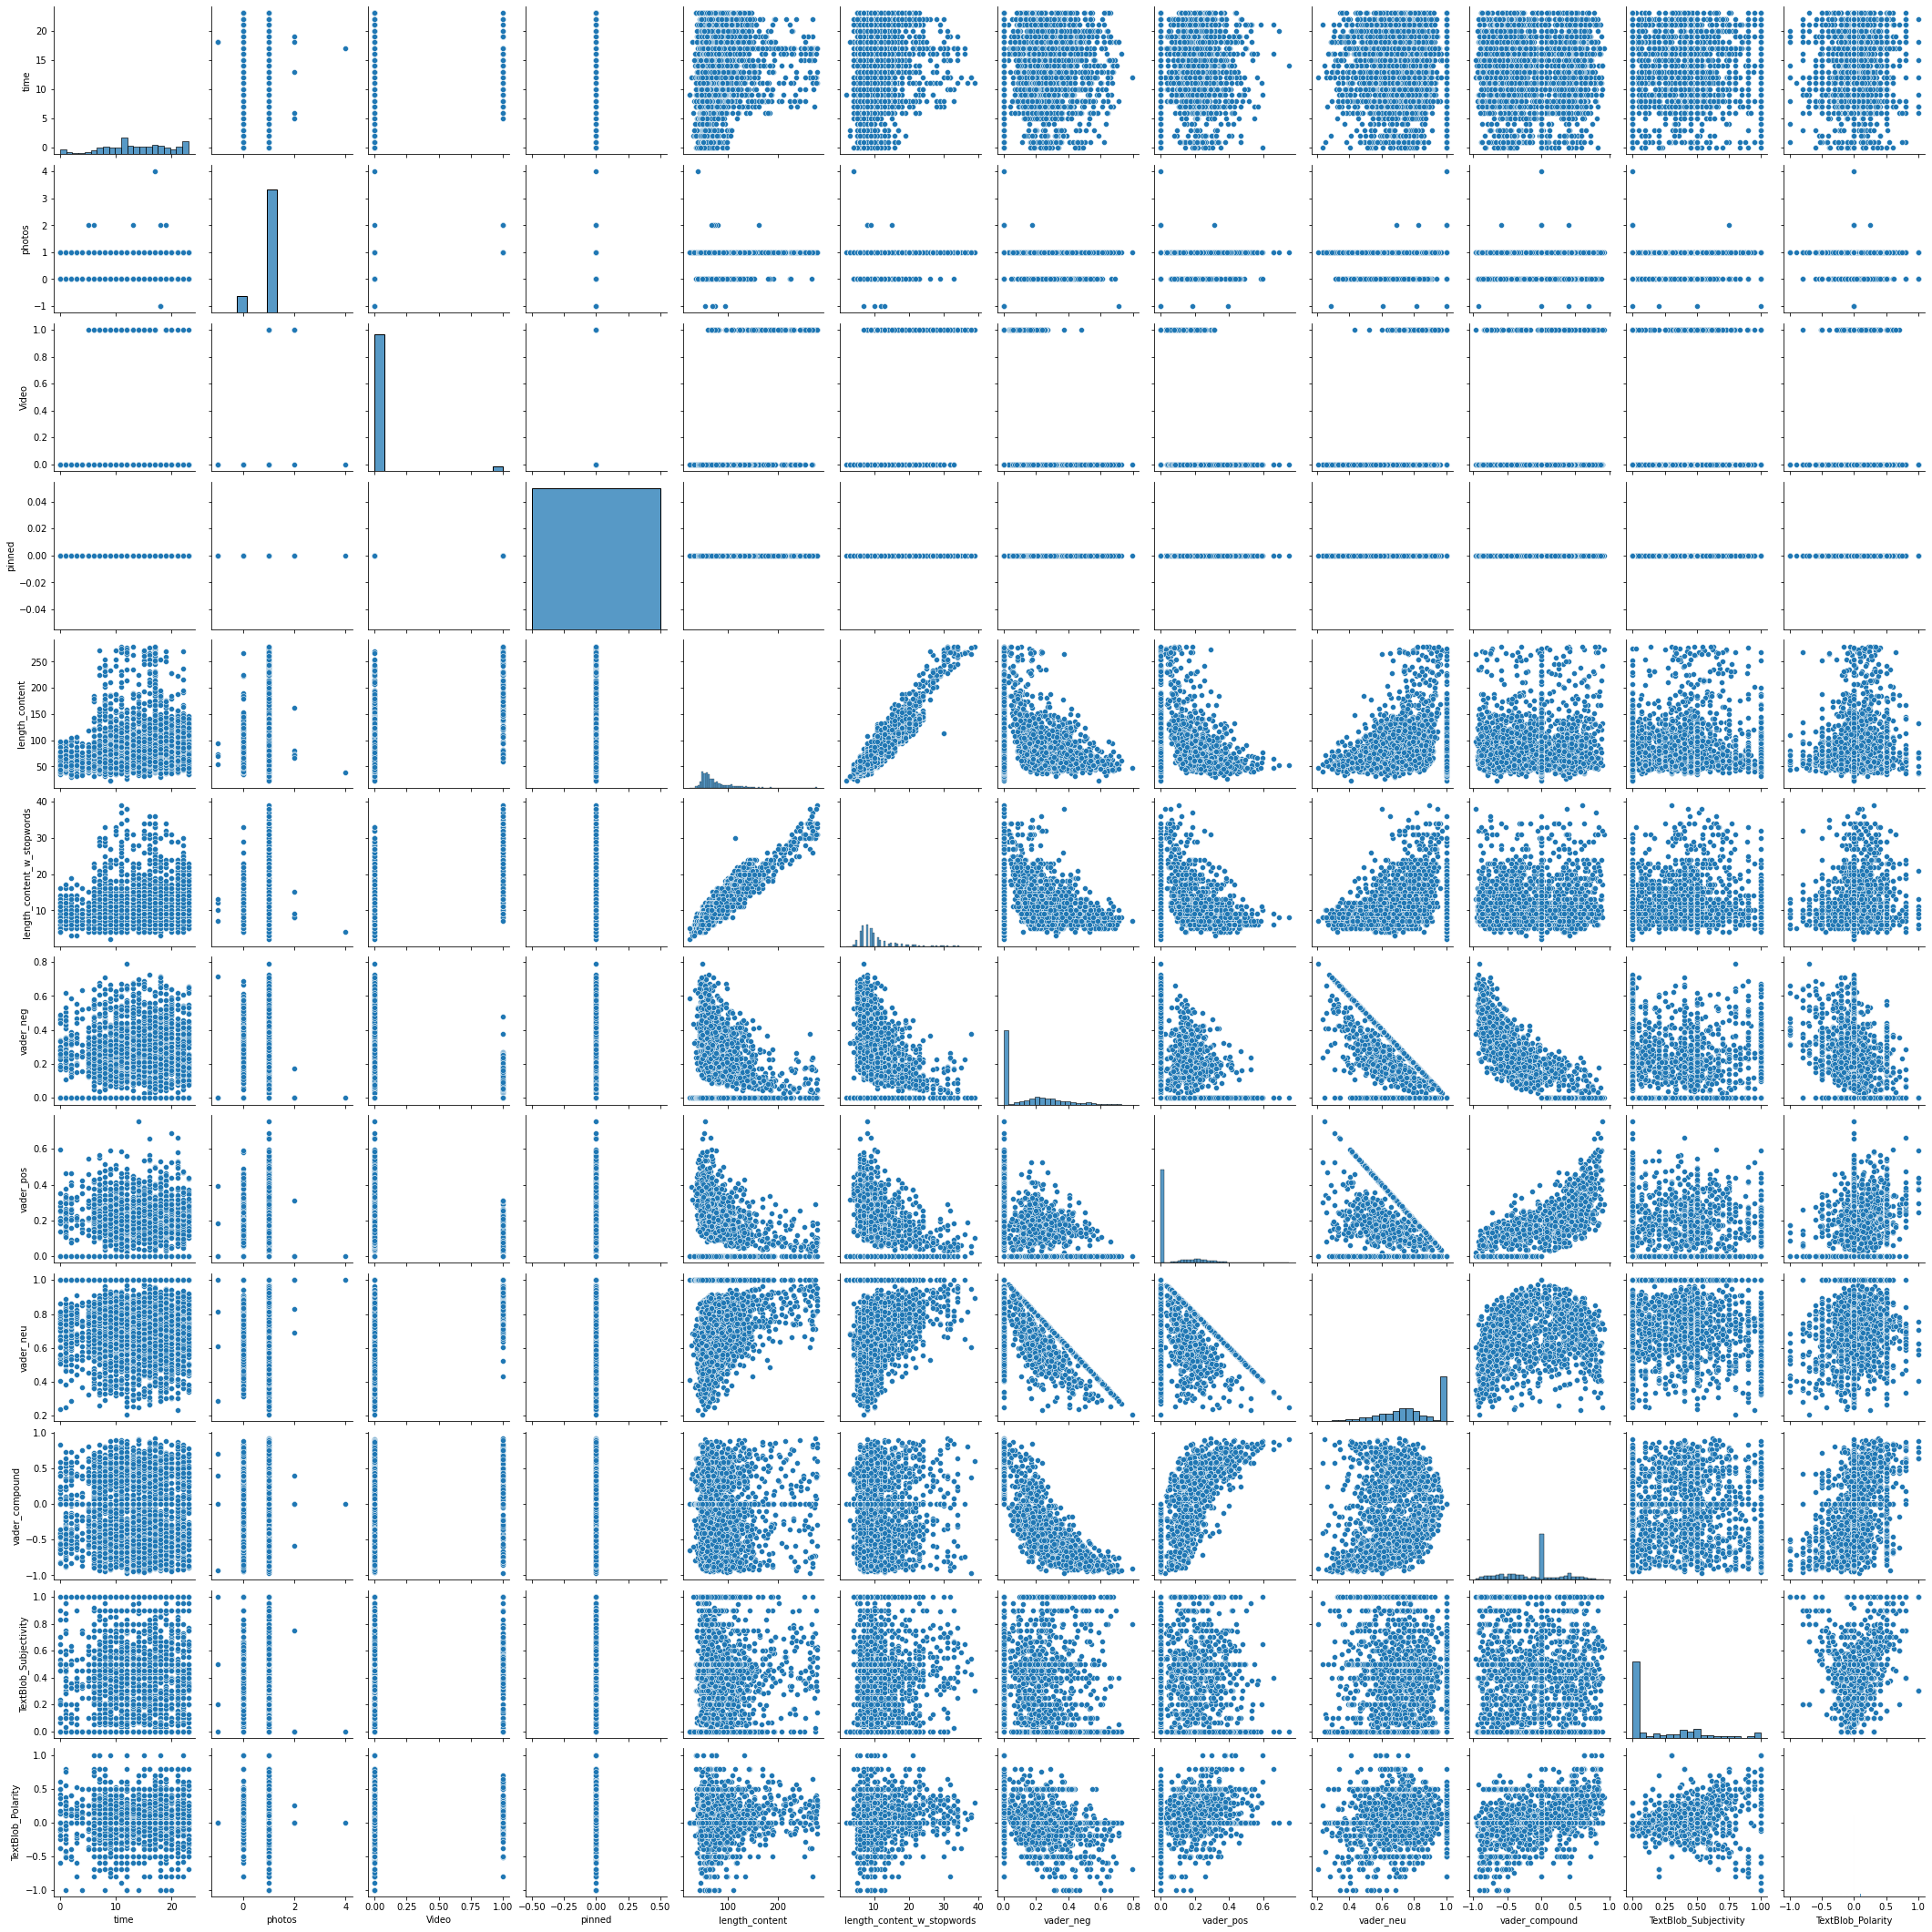

In [48]:
features = data.drop(['popularity','binned'],axis = 1)
target = data[['binned']]
sns.pairplot(features)

### KDE shows us the distribution of each column
- Here, we can see that most of the data is skewed

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

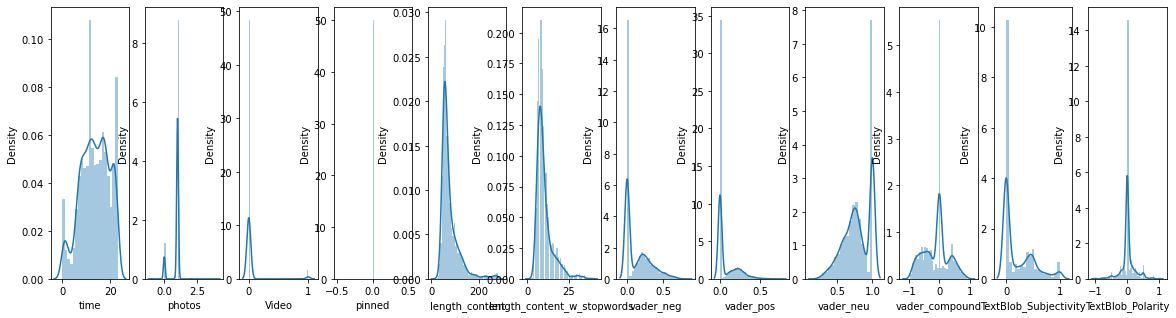

In [49]:
fig, ax = plt.subplots(1,len(features.columns), figsize=(20,5))

for i, feature in enumerate(features):
    sns.distplot(features[feature], ax=ax[i])

#### Correlation Heatmap
- This shows how the different columns are correlated

<AxesSubplot:>

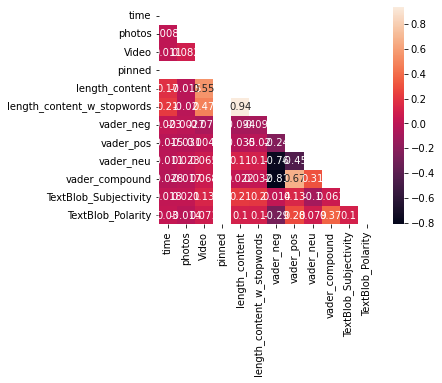

In [50]:
corr = features.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 0)] = True
sns.heatmap(corr, mask=mask, square=True, annot=True)

#### KDE for popularity field
- Strong presence of outliers

<AxesSubplot:xlabel='popularity', ylabel='Density'>

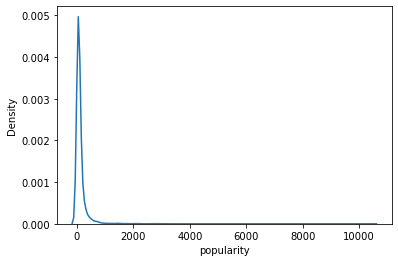

In [54]:
sns.kdeplot(data['popularity'])

#### OVERLAPPING KDE with the different bins
- to visualize the data drift between the 3 bins

time
photos
Video
pinned
singular matrix
length_content
length_content_w_stopwords
vader_neg
vader_pos
vader_neu
vader_compound
TextBlob_Subjectivity
TextBlob_Polarity


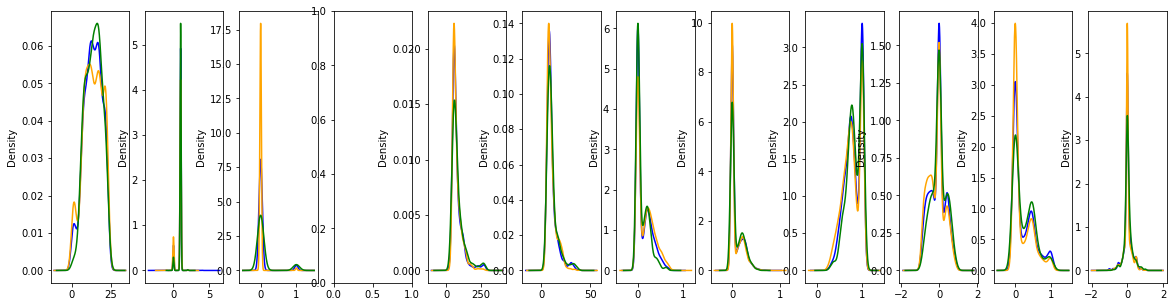

In [55]:
colors = ("blue", "orange", "green")
bins = data.binned.unique()


fig, ax = plt.subplots(1,len(features.columns), figsize=(20,5))

for i, (feature,ax) in enumerate(zip(features,ax)):
    print(feature)
    try:
        for binn,color in zip(bins,colors):
            two_dim_per_lifestyle = data[data.index.isin(list(target[target.binned == binn].index))][feature]
            two_dim_per_lifestyle.plot(x=0, y=1, kind="kde", c=color, label=binn, ax=ax)
    except Exception as e:
        print(e)

### TAKING LINEAR REGRESSION ASSUMPTIONS INTO CONSIDERTAION
- 5 assumptions for linear regression

- LINEAR RELATIONSHIP BETWEEN VARIABLES

In [56]:
corr = data.corr().abs()
features = pd.DataFrame(corr['popularity']).reset_index().sort_values(by = 'popularity' ,ascending = False)
features[1:8]

,index,popularity
2,Video,0.105117
1,photos,0.057440
7,vader_neg,0.053275
9,vader_neu,0.049773
5,length_content,0.046239
12,TextBlob_Polarity,0.038674
10,vader_compound,0.035448


- Confirm and remove multicollinearity
- Presence of similar relationships between features

- REMOVE MULTICOLINEARITY WITH CORRELATION METHOD

In [57]:
threshold = 0.8
corr_matrix = data.corr().abs()
corr_matrix.head()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(f'There are {len(to_drop)} columns to remove.')
to_drop

There are 2 columns to remove.


['length_content_w_stopwords', 'vader_compound']

- Based on assumptions, select best features

In [58]:
cols = ['Video','photos','vader_neg','vader_neu','length_content','TextBlob_Polarity']

### BASELINE MODELLING  WITH LINEAR REGRESSION

#### DIVIDE DATA INTO TRAIN AND TEST
- Split data into 70/30 %

In [59]:
# data = data[~(data['popularity'] > upper_limit) | (data['popularity'] < lower_limit)]

In [60]:
from sklearn.model_selection import train_test_split
X = data[cols]
y = data.popularity
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=2)

#### INSTANTIATING AND FITTING THE MODEL

In [61]:
from sklearn.linear_model import LinearRegression

In [62]:
lr = LinearRegression()

In [63]:
lr.fit(trainX,trainy)

LinearRegression()

#### MODEL PREDICTION

In [64]:
preds = lr.predict(testX)

#### MODEL EVALUATION

In [65]:
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

In [66]:
RMSE = sqrt(mean_squared_error(testy, preds))
r2 = r2_score(testy, preds)

In [67]:
data[['popularity']].describe()

,popularity
count,3941.000000
mean,118.155887
std,307.117785
min,4.400000
25%,32.800000
50%,54.500000
75%,109.300000
max,10438.750000


In [68]:
print(f'RMSE: {RMSE}')
print(f'r2: {r2}')
print(f'RMSE percentage of STD: {RMSE/(data.popularity.std()) * 100}')
print(f'RMSE percentage of MEAN: {RMSE/(data.popularity.mean()) * 100}')

RMSE: 169.87845601887275
r2: -0.01069251516817138
RMSE percentage of STD: 55.313780003094394
RMSE percentage of MEAN: 143.7748558920356


#### FEATURE IMPORTANCE

Feature: Video, Score: 230.7586493890008
Feature: photos, Score: 51.8953598498178
Feature: vader_neg, Score: -36.016100488306336
Feature: vader_neu, Score: 33.24470193807382
Feature: length_content, Score: -0.1876649560760028
Feature: TextBlob_Polarity, Score: 48.57616516475029


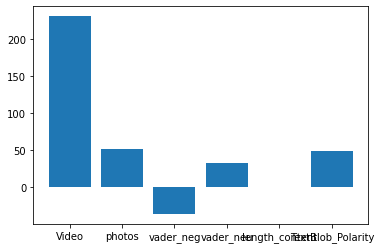

In [69]:
import matplotlib.pyplot as pyplot
importance = lr.coef_
# summarize feature importance
for i,(v,f) in enumerate(zip(importance,list(trainX.columns))):
    print(f'Feature: {f}, Score: {v}')
# plot feature importance
pyplot.bar(list(trainX.columns), importance)
pyplot.show()

### TRAIN WITH ALL COLUMNS

In [70]:
cols = ['time', 'photos', 'Video', 'pinned', 'popularity',
       'length_content', 'length_content_w_stopwords', 'vader_neg',
       'vader_pos', 'vader_neu', 'vader_compound', 'TextBlob_Subjectivity',
       'TextBlob_Polarity']

cols = ['vader_compound','TextBlob_Polarity','Video','photos','popularity']

# cols = ['Video','photos','popularity']

RMSE: 170.50657337917627
r2: -0.01818030570608853
RMSE percentage of STD: 55.51830002463316
RMSE percentage of MEAN: 144.3064564556226
Feature: vader_compound, Score: 16.259715392343182
Feature: TextBlob_Polarity, Score: 45.42645788242684
Feature: Video, Score: 210.3574319329841
Feature: photos, Score: 53.854020341712484


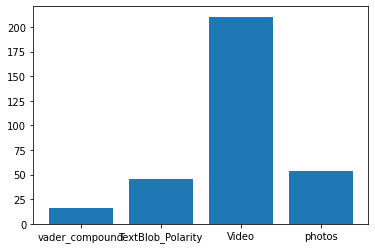

In [71]:
#### DIVIDE DATA INTO TRAIN AND TEST

from sklearn.model_selection import train_test_split
X = data[cols].drop('popularity',axis = 1)
y = data.popularity
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=2)

#### INSTANTIATING AND FITTING THE MODEL

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(trainX,trainy)

#### MODEL PREDICTION

preds = lr.predict(testX)

#### MODEL EVALUATION

from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

RMSE = sqrt(mean_squared_error(testy, preds))
r2 = r2_score(testy, preds)

data[['popularity']].describe()

print(f'RMSE: {RMSE}')
print(f'r2: {r2}')
print(f'RMSE percentage of STD: {RMSE/(data.popularity.std()) * 100}')
print(f'RMSE percentage of MEAN: {RMSE/(data.popularity.mean()) * 100}')

#### FEATURE IMPORTANCE

importance = lr.coef_
# summarize feature importance
for i,(v,f) in enumerate(zip(importance,list(trainX.columns))):
    print(f'Feature: {f}, Score: {v}')
# plot feature importance
pyplot.bar(list(trainX.columns), importance)
pyplot.show()

### MODEL WITH RANDOM FOREST

RMSE: 218.16692399162343
r2: -0.6669411051902256
RMSE percentage of STD: 71.03689025925578
RMSE percentage of MEAN: 184.64329610942315


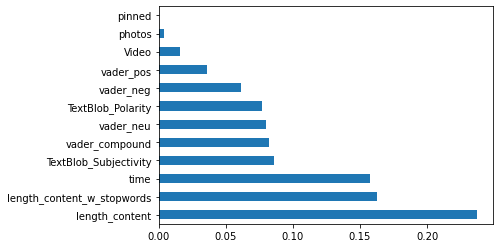

In [72]:
#### DIVIDE DATA INTO TRAIN AND TEST
cols = ['time', 'photos', 'Video', 'pinned', 'popularity',
       'length_content', 'length_content_w_stopwords', 'vader_neg',
       'vader_pos', 'vader_neu', 'vader_compound', 'TextBlob_Subjectivity',
       'TextBlob_Polarity']


from sklearn.model_selection import train_test_split
X = data[cols].drop('popularity',axis = 1)
y = data.popularity
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=2)

#### INSTANTIATING AND FITTING THE MODEL

from sklearn.ensemble import RandomForestRegressor

lr = RandomForestRegressor()

lr.fit(trainX,trainy)

#### MODEL PREDICTION

preds = lr.predict(testX)

#### MODEL EVALUATION

from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

RMSE = sqrt(mean_squared_error(testy, preds))
r2 = r2_score(testy, preds)

data[['popularity']].describe()

print(f'RMSE: {RMSE}')
print(f'r2: {r2}')
print(f'RMSE percentage of STD: {RMSE/(data.popularity.std()) * 100}')
print(f'RMSE percentage of MEAN: {RMSE/(data.popularity.mean()) * 100}')

#### FEATURE IMPORTANCE


feat_importances = pd.Series(lr.feature_importances_, index=X.columns)
feat_importances.nlargest(len(X.columns)).plot(kind='barh')
plt.show()

RMSE: 204.4032290000437
r2: -0.46324801454542364
RMSE percentage of STD: 66.55532140917538
RMSE percentage of MEAN: 172.99453669441843


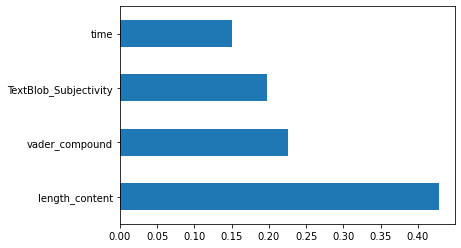

In [73]:
cols = ['time', 'photos', 'Video', 'pinned', 'popularity',
       'length_content', 'length_content_w_stopwords', 'vader_neg',
       'vader_pos', 'vader_neu', 'vader_compound', 'TextBlob_Subjectivity',
       'TextBlob_Polarity']
cols = ['length_content','time','TextBlob_Subjectivity','vader_compound','popularity']

#### DIVIDE DATA INTO TRAIN AND TEST

from sklearn.model_selection import train_test_split
X = data[cols].drop('popularity',axis = 1)
y = data.popularity
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=2)

#### INSTANTIATING AND FITTING THE MODEL

from sklearn.ensemble import RandomForestRegressor

lr = RandomForestRegressor()

lr.fit(trainX,trainy)

#### MODEL PREDICTION

preds = lr.predict(testX)

#### MODEL EVALUATION

from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

RMSE = sqrt(mean_squared_error(testy, preds))
r2 = r2_score(testy, preds)

data[['popularity']].describe()

print(f'RMSE: {RMSE}')
print(f'r2: {r2}')
print(f'RMSE percentage of STD: {RMSE/(data.popularity.std()) * 100}')
print(f'RMSE percentage of MEAN: {RMSE/(data.popularity.mean()) * 100}')

#### FEATURE IMPORTANCE


feat_importances = pd.Series(lr.feature_importances_, index=X.columns)
feat_importances.nlargest(len(X.columns)).plot(kind='barh')
plt.show()